In [1]:
from google.colab import files
import pandas as pd

#
uploaded = files.upload()

Saving Dataset modello satellite QoQ.xlsx to Dataset modello satellite QoQ.xlsx


In [14]:
data = pd.read_excel("Dataset modello satellite QoQ.xlsx")
data.head()

,Data,Tasso default,GDP,Inflation rate,Unemployment rate
0,2006-09-30,0.0181,0.007443,0.005397,-0.038461
1,2006-12-31,0.0168,0.015373,0.000000,-0.020000
2,2007-03-31,0.0170,0.004311,0.004090,-0.056122
3,2007-06-30,0.0170,0.008980,0.006365,-0.032432
4,2007-09-30,0.0175,0.010065,0.005818,0.044693


statsmodels version: 0.14.5


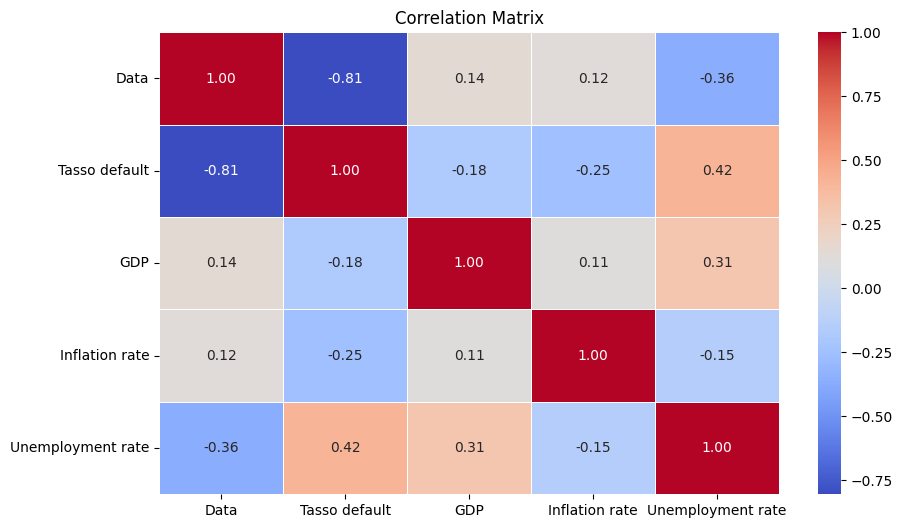

Test ADF for Tasso default:
Statistics ADF: -0.3301, P-value: 0.9211
Not Stationary
--------------------------------------------------
Test ADF for GDP:
Statistics ADF: -9.2281, P-value: 0.0000
Stationary
--------------------------------------------------
Test ADF for Unemployment rate:
Statistics ADF: -3.5384, P-value: 0.0071
Stationary
--------------------------------------------------
Test ADF for Inflation rate:
Statistics ADF: -3.1622, P-value: 0.0223
Stationary
--------------------------------------------------
        Data  Tasso default       GDP  Inflation rate  Unemployment rate  \
0 2006-09-30         0.0181  0.007443        0.005397          -0.038461   
1 2006-12-31         0.0168  0.015373        0.000000          -0.020000   
2 2007-03-31         0.0170  0.004311        0.004090          -0.056122   
3 2007-06-30         0.0170  0.008980        0.006365          -0.032432   
4 2007-09-30         0.0175  0.010065        0.005818           0.044693   

   Tasso default_dif

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
print("statsmodels version:", sm.__version__)

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, r2_score
from statsmodels.tsa.stattools import adfuller


# Upload dataset
#data = pd.read_excel("dataset\\modello satellite QoQ.xlsx")

data["Data"] = pd.to_datetime(data["Data"], errors="coerce")
numeric_cols = ["Tasso default","GDP", "Unemployment rate", "Inflation rate"]
data[numeric_cols] = data[numeric_cols].apply(pd.to_numeric, errors='coerce')


# ADF TEST
def adf_test_report(data, col):
    result = adfuller(data[col].dropna())
    return {
        "ADF Statistic": round(result[0], 4),
        "P-value": round(result[1], 4),
        "Stationary": "Yes" if result[1] < 0.05 else "No"
    }


# Descriptive statistics
summary_stats = data[numeric_cols].describe().T
summary_stats["Median"] = data[numeric_cols].median()  # median
summary_stats["Skewness"] = data[numeric_cols].skew()  # Skewness
summary_stats["Kurtosis"] = data[numeric_cols].kurtosis()  #Kurtosis


# correlations
corr_matrix = data.corr()
plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix")
plt.show()


from statsmodels.tsa.stattools import adfuller


for col in numeric_cols:
    result = adfuller(data[col].dropna())  # Remove, if there are, the NaN
    print(f"Test ADF for {col}:")
    print(f"Statistics ADF: {result[0]:.4f}, P-value: {result[1]:.4f}")
    print("Stationary" if result[1] < 0.05 else "Not Stationary")
    print("-" * 50)

#We take the diff to have stationary variables
data["Tasso default_diff"]=data["Tasso default"].diff()
data["GDP_diff"]=data["GDP"].diff()
data["Unemployment_diff"] = data["Unemployment rate"].diff()
data["Inflation rate_diff"] = data["Inflation rate"].diff()

print(data.head())

#Now we try to see if those variables are now stationart
all_cols = ["Tasso default", "GDP", "Unemployment rate", "Inflation rate", "Tasso default_diff",
            "GDP_diff","Unemployment_diff", "Inflation rate_diff"]

for col in all_cols:
    if col in data.columns:  # Verify if the colums exists in the dataset
        result = adfuller(data[col].dropna())  # Drop dei NaN
        print(f"Test ADF for {col}:")
        print(f"ADF Statistics: {result[0]:.4f}, P-value: {result[1]:.4f}")
        print("Stationary" if result[1] < 0.05 else "Not stationary")
        print("-" * 50)

####### Estimate OLS to see if there is cointegration

y = data["Tasso default"]
X = data[["GDP", "Unemployment rate", "Inflation rate"]]


X = sm.add_constant(X)

# OLS regression
model = sm.OLS(y, X, missing='drop').fit()
print(model.summary())


# take the residuals
residuals = model.resid


# Stationary test on residuals
adf_result = adfuller(residuals.dropna(), autolag='AIC')
print("\nResults ADF test on residuals:")
print(f"Statistic: {adf_result[0]:.4f}")
print(f"p-value: {adf_result[1]:.4f}")
print(f"# Lags used: {adf_result[2]}")
print(f"# Observations: {adf_result[3]}")
for key, value in adf_result[4].items():
    print(f"Critic threshold {key} : {value:.4f}")

if adf_result[1] <= 0.05:
    print("=> Residuals are stationary (I(0)).")
else:
    print("=> Residuals are not stationary.")

from statsmodels.stats.diagnostic import (
    acorr_breusch_godfrey,
    het_white,
    het_breuschpagan,
    acorr_ljungbox
)
from statsmodels.stats.stattools import jarque_bera

print("\n📊 OLS MODEL DIAGNOSTIC\n")
residuals_ols = model.resid

# Durbin-Watson
dw_stat_ols = sm.stats.stattools.durbin_watson(residuals_ols)
print(f"Durbin-Watson: {dw_stat_ols:.3f}")

# Breusch-Godfrey
bg_test_ols = acorr_breusch_godfrey(model, nlags=4)
print(f"\nBreusch-Godfrey:")
print(f"  LM stat: {bg_test_ols[0]:.3f}, p-value: {bg_test_ols[1]:.3f}")
print(f"  F stat : {bg_test_ols[2]:.3f}, p-value: {bg_test_ols[3]:.3f}")

# Ljung-Box
print("\nLjung-Box (fino al 4° lag):")
print(acorr_ljungbox(residuals_ols, lags=[1, 2, 3, 4], return_df=True))

# White test
white_test_ols = het_white(residuals_ols, model.model.exog)
print(f"\nWhite test:")
print(f"  LM stat: {white_test_ols[0]:.3f}, p-value: {white_test_ols[1]:.3f}")
print(f"  F stat : {white_test_ols[2]:.3f}, p-value: {white_test_ols[3]:.3f}")

# Breusch-Pagan
bp_test_ols = het_breuschpagan(residuals_ols, model.model.exog)
print(f"\nBreusch-Pagan:")
print(f"  LM stat: {bp_test_ols[0]:.3f}, p-value: {bp_test_ols[1]:.3f}")
print(f"  F stat : {bp_test_ols[2]:.3f}, p-value: {bp_test_ols[3]:.3f}")

# Jarque-Bera
jb_ols = jarque_bera(residuals_ols)
print(f"\nJarque-Bera:")
print(f"  JB stat: {jb_ols[0]:.3f}, p-value: {jb_ols[1]:.3f}")
print(f"  Skewness: {jb_ols[2]:.3f}, Kurtosis: {jb_ols[3]:.3f}")


#USE THE ARDL MODEL

from statsmodels.tsa.ardl import ARDL, ardl_select_order

from statsmodels.tsa.ardl import ARDL, ardl_select_order
import pandas as pd
import numpy as np
import statsmodels.api as sm

# Step 1: Automatic lag selection according to BIC criteria
model_selection = ardl_select_order(
    endog=data["Tasso default"],
    exog=data[["GDP","Unemployment rate", "Inflation rate"]],
    maxlag=4,  # Max lag dependent variable
    maxorder=4,  # Max lag independent variable
    ic= "bic"
)

# Obtain the best ARDL
best_model = model_selection.model

# Step 2: Estimate the model
results = best_model.fit()
print(results.summary())


print("\n📊 ARDL MODEL DIAGNOSTIC\n")

import statsmodels.api as sm
from statsmodels.stats.diagnostic import (
    het_white,
    het_breuschpagan
)
from statsmodels.stats.stattools import jarque_bera


residuals_ardl = results.resid
exog_ardl = results.model.exog[-len(residuals_ardl):]

#ADD A CONSTANT IF NOT ALREADY THERE
if not np.any(np.all(exog_ardl == 1, axis=0)):
    exog_ardl = sm.add_constant(exog_ardl, has_constant='add')


# Durbin-Watson
dw_stat_ardl = sm.stats.stattools.durbin_watson(residuals_ardl)
print(f"Durbin-Watson: {dw_stat_ardl:.3f}")


# Ljung-Box
print("\nLjung-Box (fino al 4° lag):")
print(acorr_ljungbox(residuals_ardl, lags=[1, 2, 3, 4], return_df=True))

# ✅ White test
try:
    white_test = het_white(residuals_ardl, exog_ardl)
    print(f"\nWhite test:")
    print(f"  LM stat: {white_test[0]:.3f}, p-value: {white_test[1]:.3f}")
    print(f"  F stat : {white_test[2]:.3f}, p-value: {white_test[3]:.3f}")
except Exception as e:
    print(f"⚠️ Error in the White test: {e}")

# ✅ Breusch-Pagan test
try:
    bp_test = het_breuschpagan(residuals_ardl, exog_ardl)
    print(f"\nBreusch-Pagan:")
    print(f"  LM stat: {bp_test[0]:.3f}, p-value: {bp_test[1]:.3f}")
    print(f"  F stat : {bp_test[2]:.3f}, p-value: {bp_test[3]:.3f}")
except Exception as e:
    print(f"⚠️ Error in the Breusch-Pagan test: {e}")

# ✅ Jarque-Bera test
jb_test = jarque_bera(residuals_ardl)
print(f"\nJarque-Bera:")
print(f"  JB stat: {jb_test[0]:.3f}, p-value: {jb_test[1]:.3f}")
print(f"  Skewness: {jb_test[2]:.3f}, Kurtosis: {jb_test[3]:.3f}")


# Take the ARDL coefficient
params = results.params

# Identify the coefficient of the lagged dependent variable (Default var % with lag)
lagged_dep_vars = [var for var in params.index if "Tasso default.L1" in var]

if lagged_dep_vars:
    phi = sum(params[lagged_dep_vars])  # Sum the coefficients of lagged dependent variable
    long_run_coefficients = params.drop(lagged_dep_vars) / (1-phi)  # Long run Coefficients

    print("\n✅ Long Run Coefficients:")
    print(long_run_coefficients)
else:
    print("\n⚠️ Error: No lag for the dependent variable. Verify lag selection.")



#######################################
# BOUND TEST
#######################################

# align dimensions between residuals and fitted_values
used_data = pd.Series(results.model.endog, index=data.index)
fitted_values = pd.Series(results.fittedvalues, index=data.index)

# RSS restricted calculation: use the avarage of the y variable
rss_restricted = np.sum((used_data - used_data.mean()) ** 2)

# Calcolo RSS unrestricted: fitted values used
rss_unrestricted = np.sum((used_data - fitted_values) ** 2)

# N params and obs
num_params = results.df_model + 1  # with costant
num_obs = len(used_data)  # N obs

#F-statistic
f_stat = ((rss_restricted - rss_unrestricted) / num_params) / (rss_unrestricted / (num_obs - num_params))

# Thresholds (Pesaran et al., 2001)
critical_values = {
    "1%": [6.84, 7.84],  # I(0), I(1) 1%
    "5%": [4.94, 5.73],  # I(0), I(1) 5%
    "10%": [4.04, 4.78]  # I(0), I(1) 10%
}

# Output  Bound Test
print("\n Bound Test results:")
print("F-statistic:", f_stat)
print("Threshold:")
for level, values in critical_values.items():
    print(f"   {level}: I(0) = {values[0]:.4f}, I(1) = {values[1]:.4f}")

# Interpretation
if f_stat > critical_values["5%"][1]:
    print("Conclusion: There is a cointegration (Positive Bound Test).")
elif f_stat < critical_values["5%"][0]:
    print("Conclusion: There is no cointegration (Negative Bound Test).")
else:
    print("Conclusion: Invalid Result (statistics between F tra I(0) e I(1)).")

import re

# Be sure that you have long_run_coefficients to calculate ECT
if not long_run_coefficients.empty:

    # Variable for the constant
    intercept = 0.0

    # This will accumulate the part "sum of coefficients * variables"
    sum_of_contributions = pd.Series(0.0, index=data.index)

    for var_name in long_run_coefficients.index:
        coeff_value = long_run_coefficients[var_name]

        # Constant management (ex. "const")
        if var_name.lower().startswith("const"):
            intercept = coeff_value

        else:
            # Remove the possibile suffix .L#, L0 o .L1, .L2
            base_name = re.sub(r"\.L\d+$", "", var_name)

            # Check if there is that column
            if base_name in data.columns:
                sum_of_contributions += coeff_value * data[base_name]
            else:
                # if we don't find it, we ignore it)
                print(f"⚠️ Attention: variable {var_name} not found in data.columns")

    # calculate l'ECT = y_t - (intercept + sum_of_contributions)
    ect = data["Tasso default"] - (intercept + sum_of_contributions)

    # Shift of the error terms to use it as ECT(t-1)
    data["ECT_L1"] = ect.shift(1)

    print("\n✅ ECT calculated.")

else:
    print("\n⚠️ Error: Empty Long Run Coefficients.")


# Create differentiated variables(ΔX_t)
diff_vars = ["GDP", "Unemployment rate", "Inflation rate"]
for var in diff_vars:
    data[f"Δ{var}"] = data[var].diff()

# Creation of (ΔY_t)
data["ΔTasso default"] = data["Tasso default"].diff()  # difference on default rate

# Creation of the dataset for l'ECM
ecm_data = data.dropna()

# ECM model
# X_ecm: costant + differencees of the variables and lagged ECT
X_ecm = sm.add_constant(ecm_data[[
    "ΔGDP",
    "ΔUnemployment rate",
    "ΔInflation rate",
    "ECT_L1"
]])
# y_ecm: difference in Default
y_ecm = ecm_data["ΔTasso default"]

# estimate ECM with OLS
ecm_model = sm.OLS(y_ecm, X_ecm).fit()

# Output del modello ECM
print(ecm_model.summary())


#############################################################

#UNRESTRICTED EMC

import pandas as pd
import statsmodels.api as sm

# 1) Be sure that data colums is index and you have numeric series
df = data.copy()          # data is DataFrame we have already cleaned
df = df.set_index('Data')

# 2) Pick the max lags
p_max  = 1     # y lags
q_max  = 1     # x lags

# 3) Build manually the differences and lagged levels -----------------
y   = 'Tasso default'
X   = ['GDP', 'Unemployment rate', 'Inflation rate']

uecm = pd.DataFrame(index=df.index)

# Lagged levels (t-1)
uecm[f'{y}_L1'] = df[y].shift(1)
for var in X:
    uecm[f'{var}_L1'] = df[var].shift(1)

# y differences
uecm[f'D_{y}'] = df[y].diff()

# Differences lagged y (∆y_{t-i})
for i in range(1, p_max):
    uecm[f'D_{y}_L{i}'] = df[y].diff().shift(i)

# Differences lagged and contemporary X
for var in X:
    uecm[f'D_{var}'] = df[var].diff()
    for j in range(1, q_max):
        uecm[f'D_{var}_L{j}'] = df[var].diff().shift(j)

# 4) Eliminate NA generated by lag/diff
uecm = uecm.dropna()

# 5) Define y  and matrix X (regressors)
y_dep = uecm[f'D_{y}']              # Δy_t
X_reg = uecm.drop(columns=[f'D_{y}'])
X_reg = sm.add_constant(X_reg)      # costant

# 6) estimate OLS of theUECM
uecm_model = sm.OLS(y_dep, X_reg).fit()
print(uecm_model.summary())



##################################################################
#Granger causality

import pandas as pd
from statsmodels.tsa.stattools import grangercausalitytests

data = data.set_index('Data')

# If necessary, we differentiate as before
data['Tasso default_diff'] = data['Tasso default'].diff()
data['GDP_diff'] = data['GDP'].diff()
data['Unemployment_diff'] = data['Unemployment rate'].diff()
data['Inflation_diff'] = data['Inflation rate'].diff()

# Eliminate rows NaN
data_diff = data[['Tasso default_diff', 'GDP_diff', 'Unemployment_diff', 'Inflation_diff']].dropna()

# 📋 Define the variables
target = 'Tasso default_diff'   #y
explanatory_vars = ['GDP_diff', 'Unemployment_diff', 'Inflation_diff']  #x

# ⚙️ Max lag for the casuality
max_lag = 3

# 🚀 Loop on X
for var in explanatory_vars:
    print(f"\n🌟 Granger Causality Test: {var} → {target}")
    grangercausalitytests(
        data_diff[[target, var]],
        maxlag=max_lag,
    )